### Import Packages

In [1]:
import sys
import time
import os
from os import listdir
from os.path import isfile, join
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, confusion_matrix

RANDOM_STATE = 42

### Functions and Utils

In [2]:
def unpickle_all_data(directory):
    """
    Description:
        Extract images, labels and label names from directory provided to numpy array.
        
    Parameters:
        Directory: Folder the CIFAR dataset is located.
        
    Return:
        train and test images and labels plus dictionary of label names
    """
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_img = []
    train_label = []
    test_img = []
    test_label = []
    
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            
            #Train data
            if 'data_batch' in filename:
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            #Test data
            elif 'test_batch' in filename:
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
            #Label names
            elif 'batches.meta' in filename:
                with open(directory + '/' + filename, 'rb') as fo:
                    label_names = pickle.load(fo)
            
    for image in train['data']:
        train_img.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_label = [label for label in train['labels']]
    
    for image in test['data']:
        test_img.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_label = [label for label in test['labels']]
    
    # Transform the data to np array format
    train_img = np.array(train_img)
    train_label = np.array(train_label)
    test_img = np.array(test_img)
    test_label = np.array(test_label)
    
    return (train_img, train_label), (test_img, test_label), label_names


def show_sample_images(images, labels, label_names):
    """
    Description:
        Display random image from the images
        
    Paramaters:
        images: images (rgb) in numpy array
        labels: labels of images in numpy array
        label_names: label name of the images in dictionary
    
    """
    NUMBER_SAMPLE_IMAGES = 10
    y_size = 2
    x_size = NUMBER_SAMPLE_IMAGES * y_size
    label_list = []
    for i in np.unique(labels):
        label_list = np.random.choice(np.where(labels == i)[0], NUMBER_SAMPLE_IMAGES).tolist()
        fig, axes = plt.subplots(1, NUMBER_SAMPLE_IMAGES, figsize= (x_size , y_size))
        fig.suptitle(label_names['label_names'][i], fontsize= 16)
        for i, ax in enumerate(axes.flat):
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.imshow(images[label_list[i]])

def show_image_distribution(label, label_names, string = None):
    fig, ax = plt.subplots(1, 1, figsize = (12, 6))
    mapper_label = dict(zip(range(10), label_names['label_names']))
    sns.countplot(pd.DataFrame(label)[0].map(mapper_label), ax = ax)
    ax.set_xlabel('Label names')
    ax.set_title(f'Distribution of {string} images', fontsize=  16)
    
def get_img_mean_std(img):
    mean_list = []
    std_list = []
    for i in [0, 1, 2]:
        mean_list.append((img[:, :, :, i] / 255.0).mean())
        std_list.append((img[:, :, :, i] / 255.0).std())
    return mean_list, std_list

class Cifar_dataset(Dataset):
    """
    Description:
        Inherit Pytorch dataset class to customize how the image is loaded and transformed.
    """
    
    def __init__(self, images, labels, transform = None, mode = None):
        self.images = images
        self.labels = labels
        self.transform = transform[mode]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if self.transform:
            img = Image.fromarray(self.images[idx])
            img = self.transform(img)
        else:
            img = self.images[idx]
        return img, self.labels[idx]

def show_training_process(df):
    """
    Description:
        Show training and testing loss and accuracy over epch
        
    Parameters:
        df : Dataframe with the training and testing processes
    """
    
    fig, ax = plt.subplots(1, 1, figsize= (24, 6))
    ax.set_title('Train and Test Accuracy vs Epoch', fontsize=  16)
    ax.set_ylabel('Accuracy', fontsize = 16)
    ax.set_xlabel('Epoch', fontsize =  16)
    sns.lineplot(x = 'Epoch', y = 'Accuracy', hue = 'Type', data = df, ax= ax)

    fig, ax = plt.subplots(1, 1, figsize= (24, 6))
    ax.set_title('Train and Test Loss vs Epoch', fontsize=  16)
    ax.set_ylabel('Accuracy', fontsize = 16)
    ax.set_xlabel('Epoch', fontsize=  16)
    sns.lineplot(x = 'Epoch', y = 'Loss', hue = 'Type', data = df, ax= ax)
    
def show_confusionmatrix(predicted_label, true_label, label_names, accuracy, epoch):
    """
    Description:
        Shows confusion matrix of predicted label and true label
        
    Parameters:
        predicted_label : Model predicted labels
        true_label : Ground truth
        label_names : Label names in string
        accuracy: Best accuracy of the prediction
        epoch: best accuracy's epoch
        
    """
    
    fig, ax = plt.subplots(1, 1, figsize = (18, 16))
    cm_df = pd.DataFrame(confusion_matrix(predicted_label, true_label), index = label_names['label_names'], columns = label_names['label_names'])
    sns.heatmap(cm_df, annot= True, ax = ax)
    ax.set_title(f'Confusion Matrix of True Label vs Predicted Label with Accuracy of {np.round(accuracy, 3)} at Epoch: {epoch + 1}', fontsize=  16)
    ax.set_ylabel('True Label', fontsize=  16)
    ax.set_xlabel('Predicted Label', fontsize=  16)
    plt.show()

In [3]:
(train_img, train_label), (test_img, test_label), label_names = unpickle_all_data('/kaggle/input/cifar10-python/cifar-10-batches-py/')

### Sample Train Data

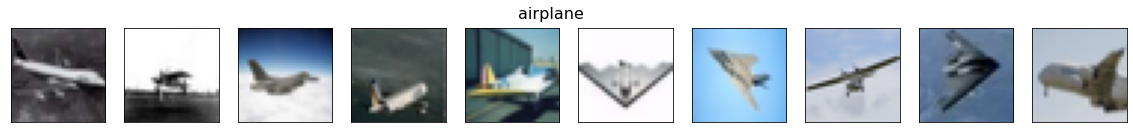

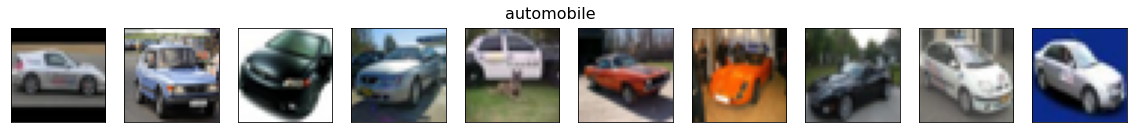

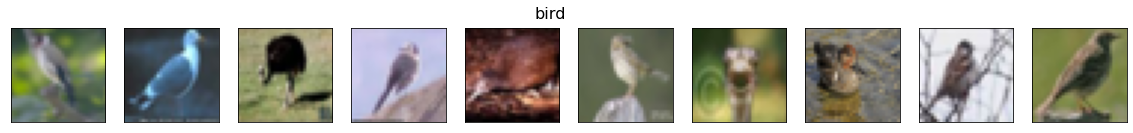

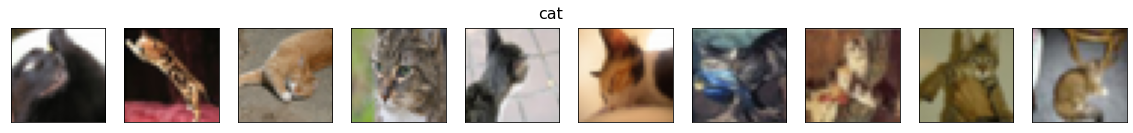

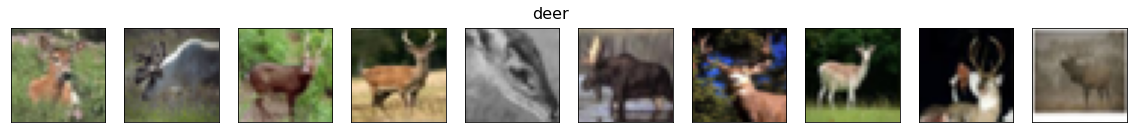

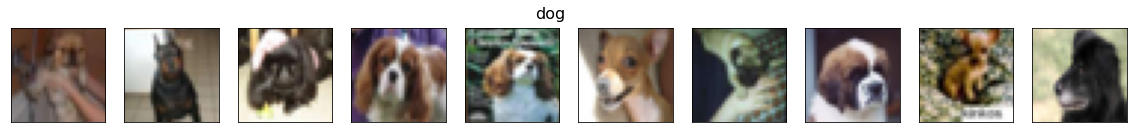

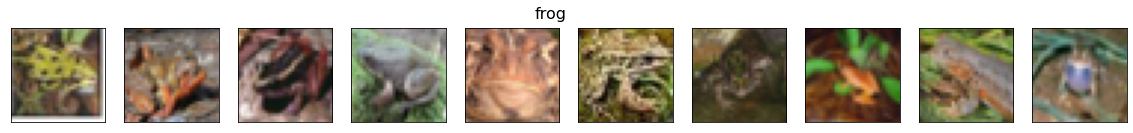

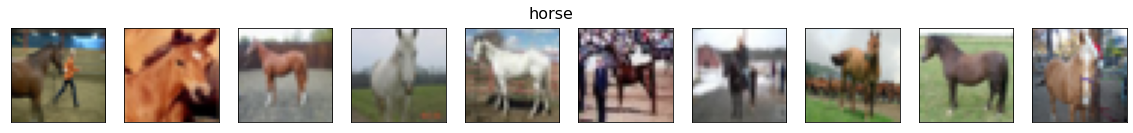

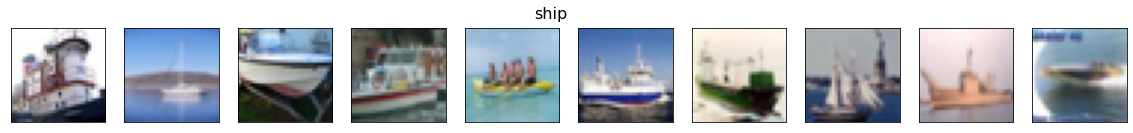

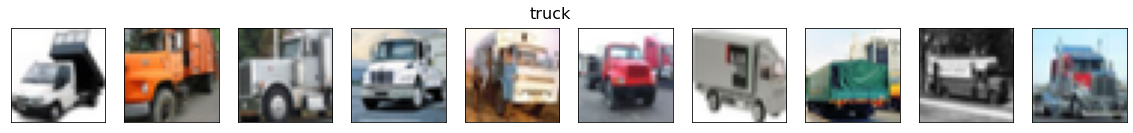

In [4]:
show_sample_images(train_img, train_label, label_names)

### Sample Test Data

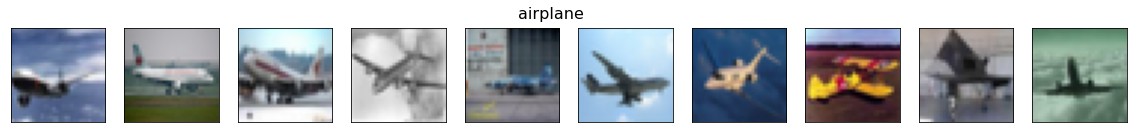

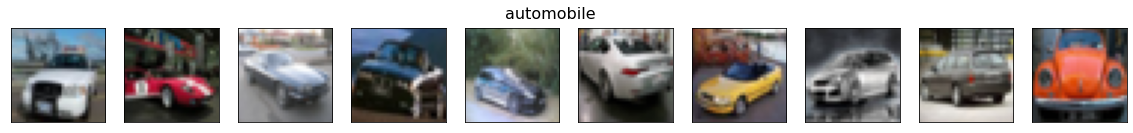

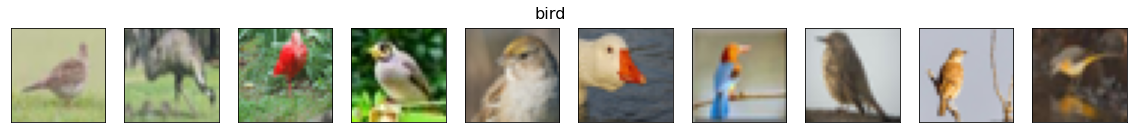

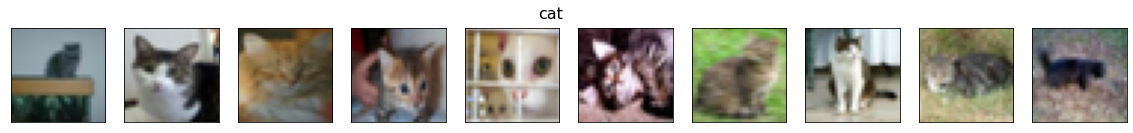

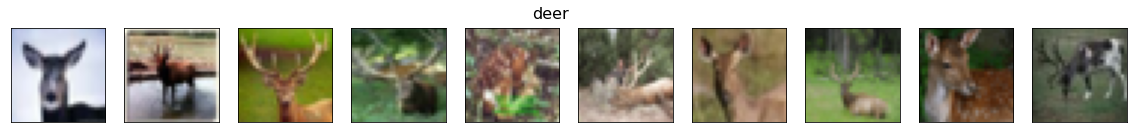

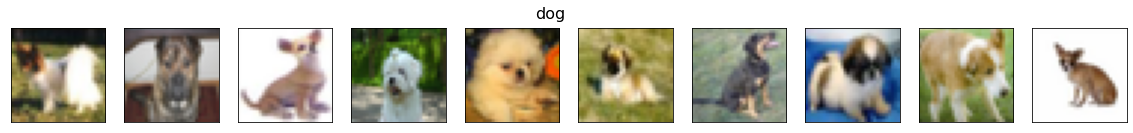

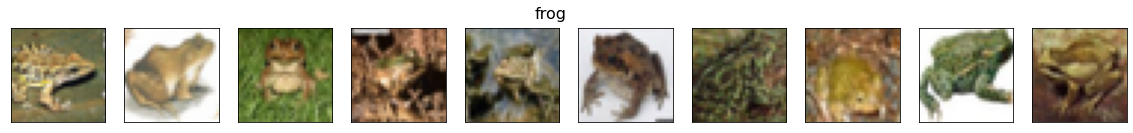

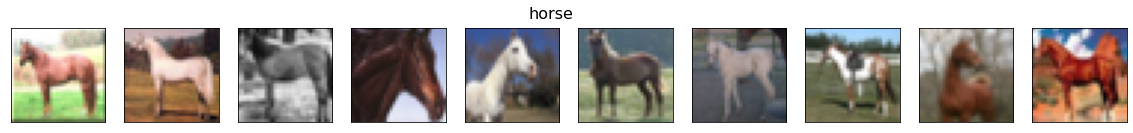

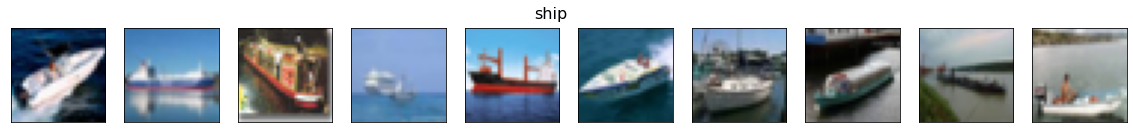

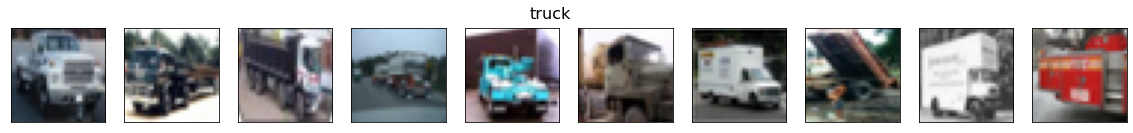

In [5]:
show_sample_images(test_img, test_label, label_names)

### Train Data Distribution

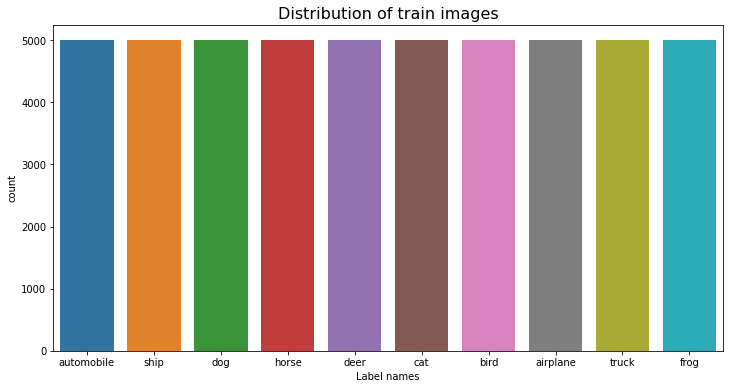

In [6]:
show_image_distribution(train_label, label_names, 'train')

### Test Data Distribution

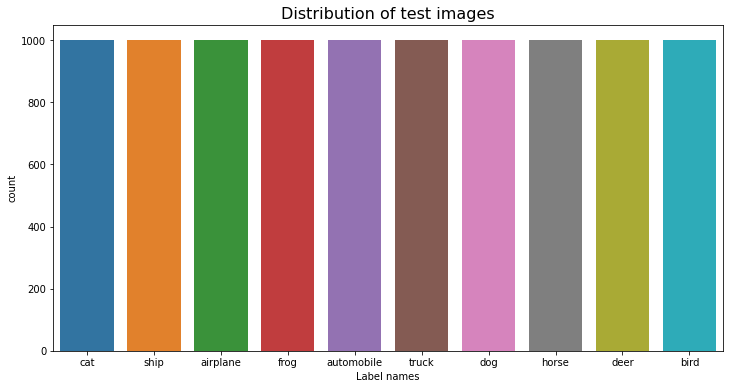

In [7]:
show_image_distribution(test_label, label_names, 'test')

### Model Preparation
* model architecture: resnet32
* number of epochs: 300
* training batch size: 128
* training data augmentation: random crop and random horizontal flip
* training optimizer: SGD
* training scheduler: Step Learning Rate

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

In [9]:
NUM_EPOCHS = 300
TRAIN_BATCHSIZE = 128
TEST_BATCHSIZE = 128

train_mean, train_std = get_img_mean_std(train_img)
img_transforms = {'train' : transforms.Compose([
                                                transforms.RandomCrop(size = 32, padding = 4),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(train_mean, train_std)]),
              'test' : transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(train_mean, train_std)])}

train_dataset = Cifar_dataset(train_img, train_label, img_transforms, 'train')
test_dataset = Cifar_dataset(test_img, test_label, img_transforms, 'test')
train_dataloader = DataLoader(train_dataset, batch_size = TRAIN_BATCHSIZE, shuffle = True, num_workers = 4)
test_dataloader = DataLoader(test_dataset, batch_size = TEST_BATCHSIZE, shuffle = False, num_workers = 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet34()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=NUM_EPOCHS // 3, gamma=0.1)

num_train_batch = len(train_dataloader)
num_test_batch = len(test_dataloader)
best_test_score = 0
total_time = 0
start_time = time.time()

df = pd.DataFrame(columns = ['Accuracy', 'Loss', 'Type', 'Epoch', 'Time'])

In [10]:
for epoch in range(NUM_EPOCHS):
    
    model.train()
    train_loss = 0
    train_accuracy = 0
    
    for train_img, train_labels in train_dataloader:
        optimizer.zero_grad()
        train_img = train_img.to(device) ; train_labels = train_labels.to(device)
        train_outputs = model(train_img)
        loss = criterion(train_outputs, train_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / num_train_batch
        train_outputs = torch.argmax(torch.softmax(train_outputs, dim = 1), axis = 1).cpu().detach().numpy() ; 
        train_labels = train_labels.cpu().detach().numpy()
        train_accuracy += accuracy_score(train_labels, train_outputs) / num_train_batch
    
    model.eval()
    test_loss = 0
    test_accuracy = 0
    
    for i, (test_img, test_labels) in enumerate(test_dataloader):
        test_img = test_img.to(device) ; test_labels = test_labels.to(device)
        test_outputs = model(test_img)
        loss = criterion(test_outputs, test_labels)
        test_loss += loss.item() / num_test_batch
        test_outputs = torch.argmax(torch.softmax(test_outputs, dim = 1), axis = 1).cpu().detach().numpy() ; 
        
        if i == 0:
            concat_test_outputs = test_outputs
        else:
            concat_test_outputs = np.concatenate((concat_test_outputs, test_outputs), axis = 0)
            
        test_labels = test_labels.cpu().detach().numpy()
        test_accuracy += accuracy_score(test_labels, test_outputs) / num_test_batch
    
        if test_accuracy > best_test_score:
            best_epoch = epoch
            best_test_score = test_accuracy
            best_concat_test_outputs = concat_test_outputs
            torch.save(model.state_dict(), 'model_best_score.pth')
            
    scheduler.step()
    total_time = time.time() - start_time
    
    df = df.append(other = {'Accuracy' : train_accuracy, 'Loss' : train_loss , 'Type' : 'train', 'Epoch' : epoch + 1, 'Time' : total_time}, ignore_index= True)
    df = df.append(other = {'Accuracy' : test_accuracy, 'Loss' : test_loss , 'Type' : 'test', 'Epoch' : epoch + 1, 'Time' : total_time}, ignore_index= True)
    
#     sys.stdout.write('\rEpoch {}  |  Train Accuracy : {:.3f}  Loss: {:.3f} |    Test Accuracy: {:.3f} Loss: {:.3f} | Total Time: {:.2f} min\n'.format(epoch + 1, train_accuracy, train_loss, test_accuracy, test_loss, total_time/60))
    

### Training and Testing process over epoch

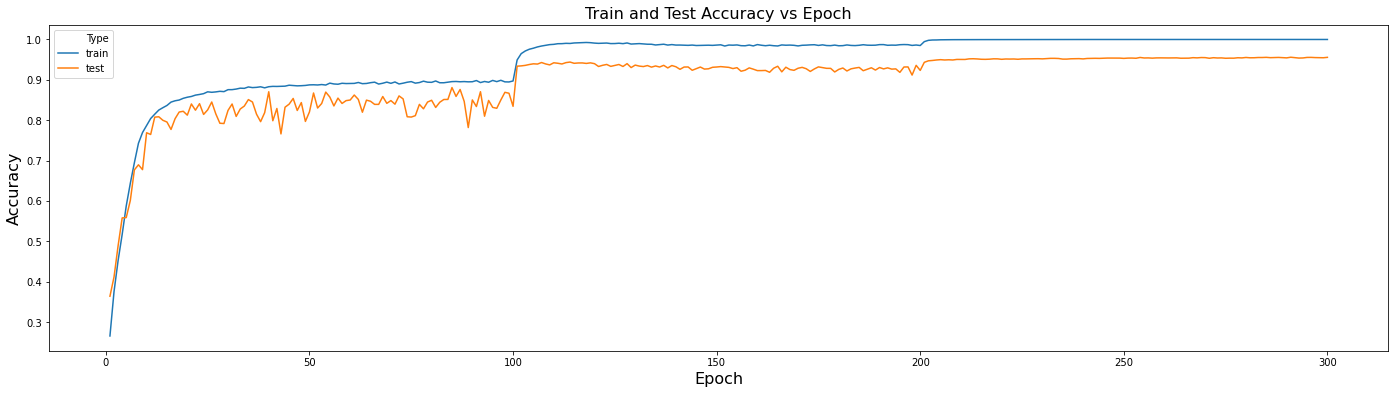

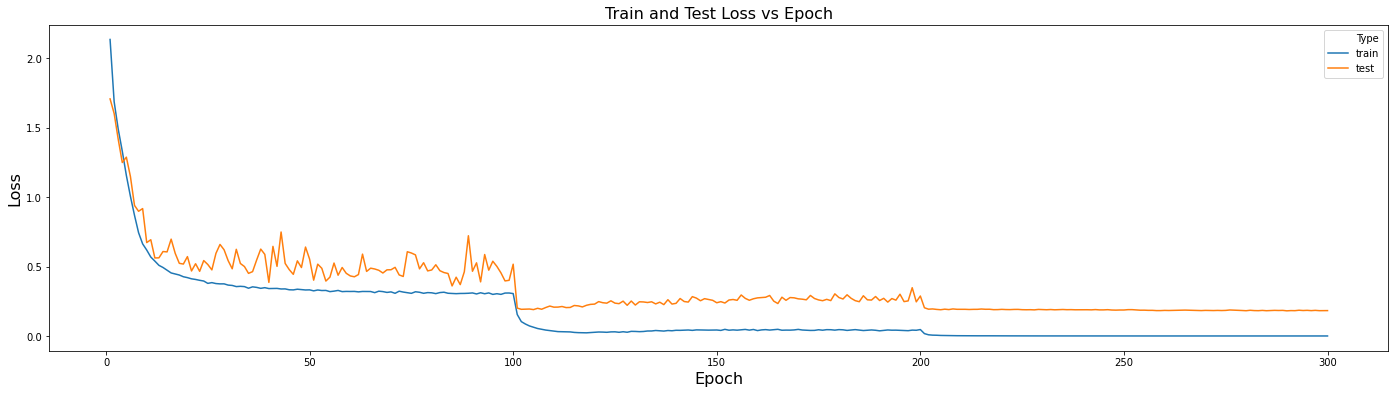

In [11]:
show_training_process(df)
df.to_csv('process.csv')

### Confusion Matrix

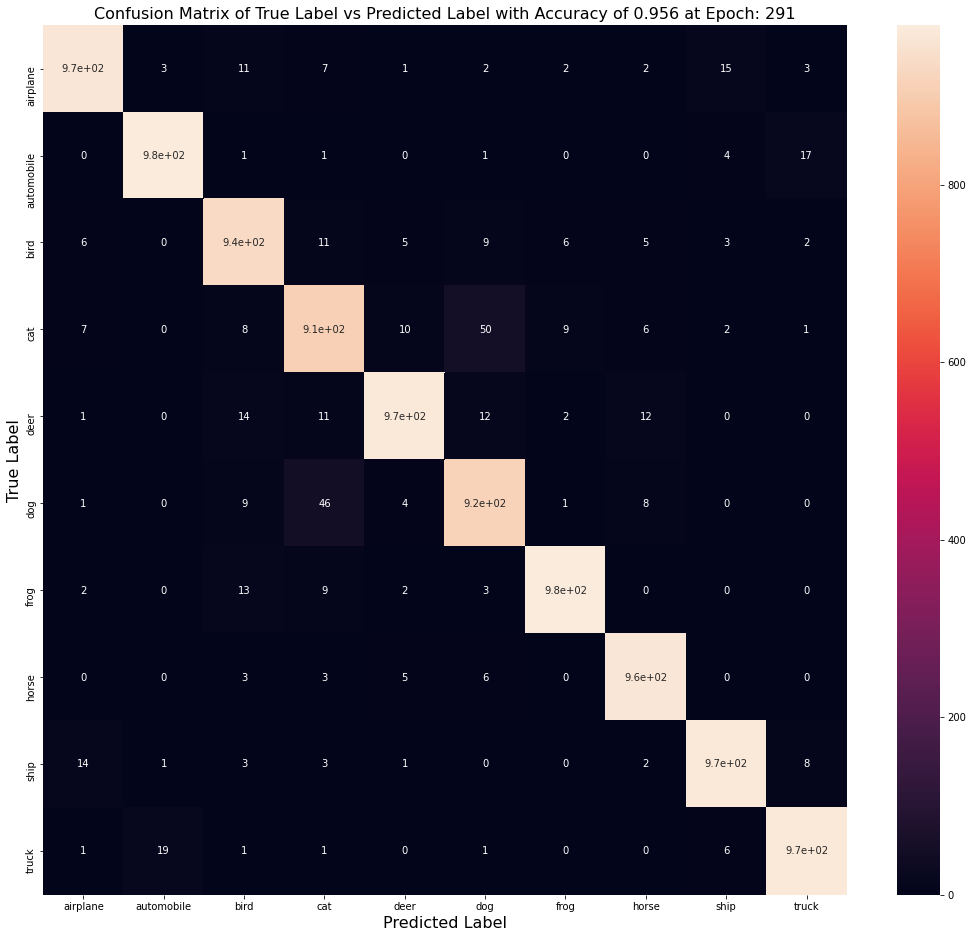

In [12]:
show_confusionmatrix(best_concat_test_outputs, test_label, label_names, best_test_score, best_epoch)